In [2]:
%pylab inline
import circlesquare
import pandas as pd
import scipy.optimize

Populating the interactive namespace from numpy and matplotlib


In [3]:
initial_params = {'num_vulns':1000, 'max_area':.01}
#assume that one day is one round?

In [36]:
data = pd.Series(index=range(0,120), #assume index of data to be (essentially) the rounds of searching
                 data=range(0,120))

In [42]:
def error(paramlist, data, iterations=1):
    """
    Runs the model with a specified set of parameters, and compares the
    error between the data set and the model output
    
    Parameters
    ----------
    paramlist : list of floats
        Parameter values for the model in array format, with elements:
        
        0. num_vulns: integer
                the number of vulnerabilities to include in the model
        
        1. max_area: float (0,1)
                the maximum likelihood that a vulnerability will be discovered
                
        2. burn_in : integer
                How many rounds of hardening to conduct before the timeseries starts?
                The burn-in period essentially allows the vulnerability distribution
                to approach that which we expect before release - that easy vulns 
                have been mostly found, and that harder ones remain.
        
        This is an array because the optimization routine
        expects to deal with things in this way.
        
    data : pandas Series
        Timeseries data to compare with the model output 
    
    iterations : integer (optional, default=1)
        How many times to run the simulation, averaging the error.
        This is desirable because the model is stochastic, and 
        multiple runs will give slightly different timeseries.
    
    Returns
    -------
    sse : float
        The sum of the squared error between the model runs and the data
        provided. Cumulative across all iterations.
    
    """
    print paramlist
    sse = 0
    for _ in range(iterations):
        output = run_it(num_vulns=paramlist[0],
                        max_area=paramlist[1],
                        tseries=data.index,
                        burn_in=paramlist[2])
        errors = data - output
        sse += sum(errors**2)
    return sse
    
def run_it(num_vulns, max_area, tseries, burn_in=0):
    """
    Parameters
    ----------
    num_vulns: integer
        The number of vulnerabilities to include in the model
    
    max_area: float (0-1)
        The maximum likelihood that a vulnerability will be discovered
    
    tseries : list of timestamps
        The times at which to sample the hardening process. 
        Not required to increase by one, but required to be increasing.
        
    burn_in : integer
        How many rounds of hardening are assumed to have 
        taken place before the timeseries begins?
        
    Returns
    -------
    cumulative_discoveries : pandas Series (optional, default 0)
        The cumulative number of discoveries made after the number
        of rounds specified in the `tseries` parameter, 
        after the burn-in period.
       
    Examples
    --------
    >>> run_it(1000, .01, range(5), 3)
    0     0
    1     4
    2     6
    3    11
    4    15
    """
    model = circlesquare.CircleSquare()
    model.make_pts(num_vulns)

    seeker = model.new_interface('Seeker')
    seeker.make_circles(max_area=max_area)
    
    seeker.harden(burn_in)
    
    t_0 = 0
    round_counts = []
    for t_1 in tseries:
        seeker.harden(t_1-t_0)
        round_counts.append({'round':model.rounds_hardened, 
                             'total':model.count_pts()}) 
        t_0 = t_1
        
    df = pd.DataFrame(index=tseries, data=round_counts)
    cumulative_discoveries = df['total'].iloc[0] - df['total']

    return cumulative_discoveries


In [38]:
run_it(1000, .01, range(10), 0)

0     0
1     5
2    13
3    15
4    18
5    20
6    26
7    33
8    37
9    40
Name: total, dtype: int64

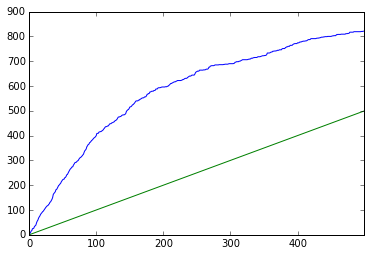

In [8]:
run_it(initial_params).plot()
data.plot()

In [39]:
%timeit error([1000,.01,0], data, 1)

1 loops, best of 3: 19.2 s per loop


In [43]:
scipy.optimize.minimize(error, [1000,.01,0],
                        method='L-BFGS-B',
                        bounds=[(0,1000),(0,1),(0,50)],
                        args=(data, 1), 
                        options={'maxiter':10})

[  1.00000000e+03   1.00000000e-02   0.00000000e+00]
[  1.00000000e+03   1.00000000e-02   0.00000000e+00]
[  1.00000000e+03   1.00000100e-02   0.00000000e+00]
[  1.00000000e+03   1.00000000e-02   1.00000000e-08]
[ 0.  0.  0.]
[  1.00000000e-08   0.00000000e+00   0.00000000e+00]
[  0.00000000e+00   1.00000000e-08   0.00000000e+00]
[  0.00000000e+00   0.00000000e+00   1.00000000e-08]
[  6.67166292e+02   6.67166292e-03   0.00000000e+00]
[  6.67166292e+02   6.67166292e-03   0.00000000e+00]
[  6.67166292e+02   6.67167292e-03   0.00000000e+00]
[  6.67166292e+02   6.67166292e-03   1.00000000e-08]
[  8.89646565e+02   8.89646565e-03   0.00000000e+00]
[  8.89646565e+02   8.89646565e-03   0.00000000e+00]
[  8.89646565e+02   8.89647565e-03   0.00000000e+00]
[  8.89646565e+02   8.89646565e-03   1.00000000e-08]
[  9.55266165e+02   9.55266165e-03   0.00000000e+00]
[  9.55266165e+02   9.55266165e-03   0.00000000e+00]
[  9.55266165e+02   9.55267165e-03   0.00000000e+00]
[  9.55266165e+02   9.55266165e-

   status: 2
  success: False
     nfev: 84
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      fun: 4499356
        x: array([  1.00000000e+03,   1.00000000e-02,   0.00000000e+00])
  message: 'ABNORMAL_TERMINATION_IN_LNSRCH'
      jac: array([  1.16515300e+14,   2.89384000e+13,   1.49389300e+14])
      nit: 0